In [14]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
#from astropy import constants as const
import pickle
from astropy.table import Table,join
from scipy import stats
from astropy.io import ascii
plt.rcParams['savefig.facecolor'] = 'white'
from astroML.plotting.mcmc import convert_to_stdev
from scipy.stats import norm, anderson
from astroML.stats import mean_sigma, median_sigmaG
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Written: 8-25-25**

**Last Updated: 9-2-25**

This python notebook exists to study the differential abundances in M15 and M92 derived by Evan Kirby. We want to study the r-process here, including the log likelihood probabilities, etc.

As a user, just change the data path and run all cells. 

Notebook structure:

1) Load relevant abundance data. Assuming pickle routine. **This is where you need to put absolute path to your data everytime you update the data, Evan**

2) Clean data and display

3) Relevant equations for log likelihood probabilities

4) Set up functions

5) Execute log-likelihood functions and return relevant output

In [15]:
# Set up data
data = '/raid/caltech/hires/M15_M92/avg_abund.pkl'

In [16]:
#Clean up data and display

with open(data, 'rb') as f:
    cat = pickle.load(f)
    avg_abunds = pickle.load(f)
    star_names = pickle.load(f)
    
gcs = ['M15', 'M92']
for i,gc in enumerate(gcs):
    a = avg_abunds[i]
    for j,el in enumerate(a['element']):
        mask = np.isfinite(a['abunddiff'][j]) & np.isfinite(a['abunddifferr'][j]) & (np.array(a['abunddifferr'][j]) > 0) #make sure to only take logical data
        abunddiff = np.array(a['abunddiff'][j])[mask]
        if len(abunddiff) == 0:
            continue
        abunddifferr = (np.array(a['abunddifferr'][j])[mask])**(-2)
        meanabund = np.average(abunddiff, weights=abunddifferr)
        #print(f"Globular Cluster: {gc}, Star: Element: {el}, Mean abundance difference: {meanabund}")

display(pd.DataFrame(avg_abunds[0]))

,element,avgabund,abund,abunderr,abunddiff,abunddifferr,abund_mc,abunddiff_mc
0,Al,4.296472,"[4.125177457984589, 4.167722820313835, 4.33287...","[0.034463014873626935, 0.03781550135412986, 0....","[0.18603819265931412, 0.15842083000021354, 0.0...","[0.034463014873626935, 0.03781550135412986, 0....","[[0.10723741899504853, -0.022890006630811085, ...","[[-0.011082345666186237, 0.03113193632881739, ..."
1,Ba,-0.138579,"[0.024344925130476057, -0.4552775481455531, -0...","[0.06340789196674092, 0.06019044042412273, 0.0...","[0.16269404895683703, -0.3181435499041844, 0.0...","[0.06340789196674092, 0.06019044042412273, 0.0...","[[0.11432973056884937, -0.03209514521027193, 0...","[[-0.006006229458774079, 0.03006876260940372, ..."
2,Ca,4.199560,"[4.194536429675876, 4.163428652379733, 4.18196...","[0.012945811588796841, 0.015967970633593717, 0...","[-0.004814544843526758, -0.04183457788406131, ...","[0.012945811588796841, 0.015967970633593717, 0...","[[0.0733455988694674, -0.030721476804180393, 0...","[[-0.004304340469099506, 0.00725024641003112, ..."
3,Ce,-0.370070,"[-0.3724273649980748, nan, -0.3835247959241706...","[0.08734711223756457, nan, 0.09703326898073497...","[0.001243895008173876, nan, -0.010545560081928...","[0.08734711223756457, nan, 0.09703326898073497...","[[0.08507174365389827, 0.046144915946859905, 0...","[[0.009014901301067286, 0.06063052901074094, -..."
4,Co,2.686980,"[2.707163352764417, 2.722700324358965, 2.71850...","[0.045102311043261394, 0.05396561946603082, 0....","[0.029180011567118032, 0.03318776334475881, 0....","[0.045102311043261394, 0.05396561946603082, 0....","[[0.1015680247706063, -0.0325190563565467, 0.1...","[[-0.0190957796438418, 0.016117510495778246, 0..."
5,Cr,3.022725,"[3.030719902208212, 3.011589257204249, 3.03076...","[0.022987998317043783, 0.026258006091732657, 0...","[0.0026026068522528277, -0.025207103659261956,...","[0.022987998317043783, 0.026258006091732657, 0...","[[0.09173996423379992, -0.02853764771775926, 0...","[[0.019504942982166013, 0.017568004077059555, ..."
6,Dy,-0.417986,"[-0.3810574308786211, -0.765999972820282, -0.6...","[0.10629404652813705, 0.1737948635792965, 0.12...","[0.03621350016218161, -0.35677775823407704, -0...","[0.10629404652813705, 0.1737948635792965, 0.12...","[[0.11090976635707396, 0.05584417993274029, 0....","[[-0.02261286737737814, 0.11198136323221533, -..."
7,Eu,-1.119841,"[-0.9938718858113275, -1.4004929508475232, -1....","[0.07695205267710659, 0.08502504188302423, 0.0...","[0.10660444897268673, -0.29983098207916203, 0....","[0.07695205267710659, 0.08502504188302423, 0.0...","[[0.11887939329449158, -0.061503781629658937, ...","[[0.026175821962173468, -0.03550835232453394, ..."
8,Fe,4.996304,"[4.999271683205862, 4.994597890641, 5.00084575...","[0.0069934184966697595, 0.008263586892727964, ...","[0.007449065842135578, -0.00875991300502833, 0...","[0.0069934184966697595, 0.008263586892727964, ...","[[0.09105141890441772, -0.03998137760265699, 0...","[[-0.0035474565189298653, 0.005372180358558994..."
9,K,3.248333,"[3.2579998970031734, 2.9779999256134038, 3.207...","[0.06771385787543269, 0.07626115646471884, 0.0...","[0.009666575325860016, -0.2703333960639105, -0...","[0.06771385787543269, 0.07626115646471884, 0.0...","[[0.05799984931945801, -0.05000019073486328, 0...","[[-0.008111238479614258, 0.0028887316584587097..."


Text(0.5, 0.98, 'M15 $r$-process Element Abundances')

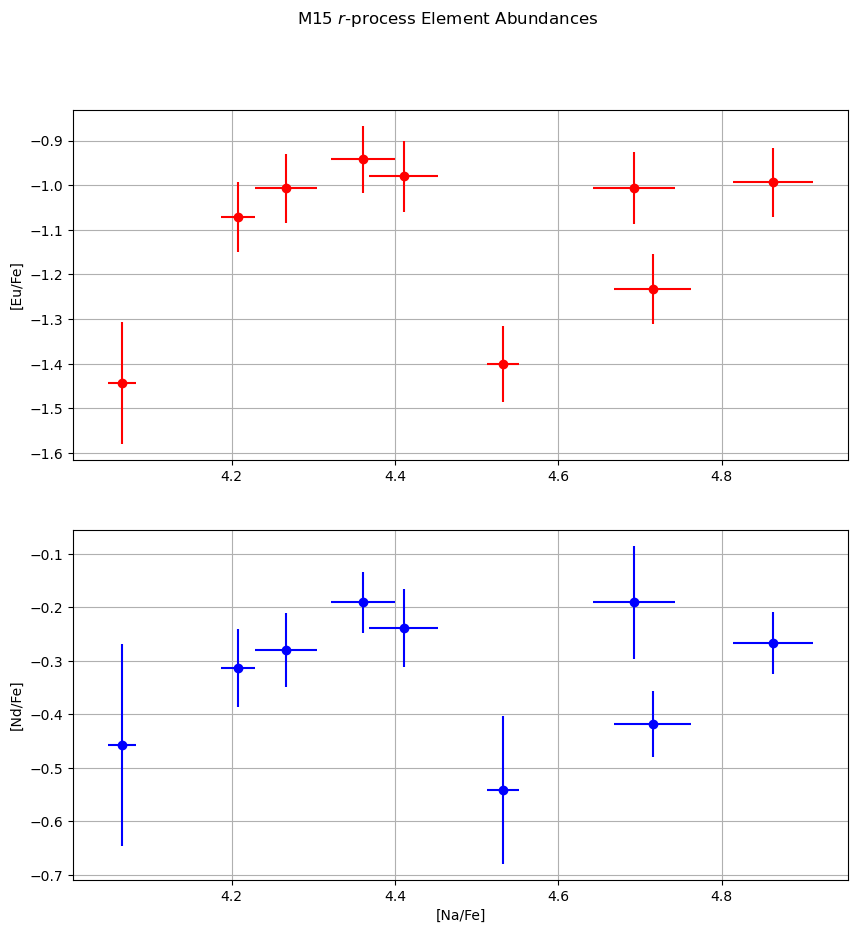

In [17]:
#Quickly test to make sure abundances make sense. Plot abundances in M15

M15_abunds = avg_abunds[0]
Na_index = np.where(M15_abunds['element'] == 'Na')[0][0]
Eu_index = np.where(M15_abunds['element'] == 'Eu')[0][0]
Nd_index = np.where(M15_abunds['element'] == 'Nd')[0][0]

sodium_M15 = M15_abunds.iloc[Na_index]['abund']
sodium_M15_error = M15_abunds.iloc[Na_index]['abunderr']

europium_M15 = M15_abunds.iloc[Eu_index]['abund']
europium_M15_error = M15_abunds.iloc[Eu_index]['abunderr']

neodymium_M15 = M15_abunds.iloc[Nd_index]['abund']
neodymium_M15_error = M15_abunds.iloc[Nd_index]['abunderr']

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].errorbar(sodium_M15, europium_M15, xerr=sodium_M15_error, yerr=europium_M15_error, fmt='o', color = 'red')
axs[0].grid()
axs[0].set_ylabel('[Eu/Fe]')

axs[1].errorbar(sodium_M15, neodymium_M15, xerr=sodium_M15_error, yerr=neodymium_M15_error, fmt='o', color = 'blue')
axs[1].grid()
axs[1].set_xlabel('[Na/Fe]')
axs[1].set_ylabel('[Nd/Fe]')

plt.suptitle(r'M15 $r$-process Element Abundances')


**8-25-25**

Data reading is great! Let's now try to get log-likelihood probabilities for these abundances.

1) The actual abundances
2) Via the differential abundances, i.e. the differences between each star and the "program star"

Math for log likelihood (and code) from M5 KOA analysis done by Pranav Nalamwar and Evan Kirby.:

$L \propto e^{\dfrac{-(x-\mu)^2}{2 (\sigma^2 + \delta x^2)}}$, where $\mu, ~ \sigma$ is the mean and standard deviation (we want the STD as it represents the intrinsic dispersion in the cluster). 


The full equation for gaussian is : $L = \frac{1}{\sqrt{2 \pi (\sigma^2 + \delta x^2)}} e^{\dfrac{-(x-\mu)^2}{2 (\sigma^2 + \delta x^2)}}$

We could minimize this by taking the negative of the likelihood but over all the stars! Over all stars, we multiply the likelihoods together. For convenience, let's do the negative log likelihood!

$ln(L) = const ~ - \frac{1}{2}  \sum_{i=1}^{n} (ln(\sigma^2 + \delta x_i^2) + \dfrac{(x_i - \mu)^2}{(\sigma^2 + \delta x_i ^2)})$  .... Stick this into a minimizer to get at the correct value of $\sigma$ for each element? 

In [18]:
#Now set up functions for log likelihood work

def gaussgauss_logL(xi, ei, mu, sigma):
    ''''
    Written: 7-11-25
    Last Updated: 7-11-25
    Equation 5.63 of AstroML book: gaussian likelihood with gaussian errors

    Inputs
    --------
    xi: abundances [X/Fe] for each stars
    ei: error on abundance
    mu: mean for dataset
    sigma: standard deviation for dataset (desired)

    Output
    --------
    log likelihood value

    '''
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)



def get_likelihood(abundances, errors, z_score = 2, plot = True, title = ''):

    '''
    Compute the log likelihood values and return the optimal mu and sigma based on the maximum likelihood estimation. Show a plot of the likelihood surface.
    Written: 7-11-25
    Last Updated: 7-15-25 (change to 2 sigma error bars instead of 3)

    Inputs
    --------
    abundances: array of abundances [X/Fe] for all stars of desired dataset
    errors: asociated [X/Fe] errors for all stars of desired dataset
    z_score: z-score value for the confidence interval (default is 2 for 95.45% CI). Values can be 1, 2, 3
    plot: boolean, if True, will plot the likelihood surface

    Returns
    --------
    mu_actual: The "actual" or rather best guess at mean abundance for the dataset (with lower and upper values)
    sigma_actual: The "actual" or rather best guess at standard deviation of the abundance for the dataset (with lower and upper values)
    '''
    
    #for the starting mean, we will use the weighted mean of the abundances
    weights = 1 / (errors ** 2)
    mu_estimated = np.sum(abundances * weights) / np.sum(weights)

    #for the starting standard deviation, we will use the weighted standard deviation from https://www.itl.nist.gov/div898/software/dataplot/refman2/ch2/weightsd.pdf
    N = len(abundances)
    sigma_estimated = np.sqrt(np.sum(weights * (abundances - mu_estimated) ** 2) / (((N - 1) / N) * np.sum(weights)))

    #Now define potential sigma and mu values to compute the log likelihood
    sigma = np.linspace(0, 3 * sigma_estimated, 150)
    mu = np.linspace(min(abundances), max(abundances), 150)

    #Compute the possible log likelihood values and normalize
    logL = gaussgauss_logL(abundances, errors, mu, sigma[:, np.newaxis])
    logL -= logL.max()

    #Now find the location of the best sigma and mu values
    index_sigma_actual = np.where(logL == logL.max())[0][0]
    index_mu_actual = np.where(logL == logL.max())[1][0]
    sigma_actual = sigma[index_sigma_actual]
    mu_actual = mu[index_mu_actual]

    #Find and plot the error in the instrinsic dispersion sigma by finding locations with a z-score = +/- 2 (so 95.45 percent confidence interval)
    if z_score == 1: z_score_value = .6827
    elif z_score == 2: z_score_value = .9545
    elif z_score == 3: z_score_value = .9974

    #Bring to cumulative standard deviations first, i.e. range from 0 to 1. Note that because our contours explore 2d space!
    converted = convert_to_stdev(logL) 
    stds_along_mu_actual = converted[:, index_mu_actual]

    #Find values near z_score_value
    indices_z_disp = np.where(np.isclose(stds_along_mu_actual, z_score_value, atol=8e-3))[0] 
    upper_disp = max(sigma[indices_z_disp])
    lower_disp = min(sigma[indices_z_disp])
    diff_upper_disp = np.abs(upper_disp - sigma_actual)
    diff_lower_disp = np.abs(sigma_actual - lower_disp)

    if (upper_disp > sigma_actual) and (lower_disp > sigma_actual):

        lower_disp = 0
        diff_lower_disp = 0

    elif (upper_disp < sigma_actual) and (lower_disp < sigma_actual):

        upper_disp = max(sigma)
        diff_upper_disp = 0

    #Also do this for the mean abundance mu, which is easier
    stds_along_sigma_actual = converted[index_sigma_actual,:]

    indices_z_mu = np.where(np.isclose(stds_along_sigma_actual, z_score_value, atol=8e-3))[0]
    upper_mu = max(mu[indices_z_mu])
    lower_mu = min(mu[indices_z_mu])
    diff_upper_mu = np.abs(upper_mu - mu_actual)
    diff_lower_mu = np.abs(mu_actual - lower_mu)

    if (upper_mu > mu_actual) and (lower_mu > mu_actual):

        lower_mu = 0
        diff_lower_mu = 0

    elif (upper_mu < mu_actual) and (lower_mu < mu_actual):

        upper_mu = max(mu)
        diff_upper_mu = 0

    # plot the results
    if plot:

        # Plot the likelihood surface
        fig = plt.figure(figsize=(10,8))
        plt.imshow(logL, origin='lower',
                extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
                cmap=plt.cm.binary,
                aspect='auto')
        plt.colorbar().set_label(r'$\log(L)$')  
        plt.clim(-5, 0)

        plt.contour(mu, sigma, convert_to_stdev(logL),
                    levels=(0.6827, 0.9545, 0.9974),
                    colors='k')

        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')

        plt.scatter(mu_actual, sigma_actual, s = 35, label='found value', color = 'yellow')
        plt.scatter(mu_estimated, sigma_estimated, s = 35, label='starter value', color = 'red')
        plt.plot(np.ones(2)*mu_actual, [lower_disp, upper_disp], marker='o', color='green', alpha = 0.8)
        plt.plot([lower_mu, upper_mu], np.ones(2)*sigma_actual, marker='o', color='green', alpha = 0.8)
        plt.title(title)
        plt.legend()
        plt.show()

        #Also show the plot of log(L) at best mu (so a cut)
        plt.figure(figsize=(10, 8))
        plt.plot(sigma, logL[:,index_mu_actual])
        plt.axvline(x=sigma_actual, color='red', linestyle='--', label=f'actual $\sigma$ = {sigma_actual:.2f}')
        plt.axvline(x = lower_disp, color = 'green', linestyle='--', label=f'lower bound $\sigma$ = {lower_disp:.2f}')
        plt.axvline(x = upper_disp, color = 'green', linestyle='--', label=f'upper bound $\sigma$ = {upper_disp:.2f}')
        plt.grid()
        plt.legend()
        plt.xlabel(r'$\sigma$')
        plt.ylabel(r'$\log(L)$ at best $\mu$')
        plt.title(f'Log(L) at best $\mu =$ {mu_actual:.2f}')
        plt.show()

        #Also show the plot of log(L) at best sigma (so a cut)
        plt.figure(figsize=(10, 8))
        plt.plot(mu, logL[index_sigma_actual,:])
        plt.axvline(x=mu_actual, color='red', linestyle='--', label=f'actual $\mu$ = {mu_actual:.2f}')
        plt.axvline(x = lower_mu, color = 'green', linestyle='--', label=f'lower bound $\mu$ = {lower_mu:.2f}')
        plt.axvline(x = upper_mu, color = 'green', linestyle='--', label=f'upper bound $\mu$ = {upper_mu:.2f}')
        plt.grid()
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\log(L)$ at best $\sigma$')
        plt.title(f'Log(L) at best $\sigma =$ {sigma_actual:.2f}')
        plt.show()


        print(f"The best sigma we got is {sigma_actual:.2f}")
        print(f"Corresponding lower and upper bound for instrisic dispersion {z_score} z-score are {lower_disp:.2f} and {upper_disp:.2f}")
        print(f"Thus, our $\sigma_i$ within a {z_score}-zscore interval is {sigma_actual:.2f} - {diff_lower_disp:.2f} and {sigma_actual:.2f} + {diff_upper_disp:.2f}")

        print(f"\n")

        print(f"The best mu we got is {mu_actual:.2f}")
        print(f"Corresponding lower and upper bound for mean abundance at {z_score} z-score are {lower_mu:.2f} and {upper_mu:.2f}")
        print(f"Thus, our $\mu_i$ within a {z_score}-zscore interval is {mu_actual:.2f} - {diff_lower_mu:.2f} and {mu_actual:.2f} + {diff_upper_mu:.2f}")
        

    return mu_actual, diff_lower_mu, diff_upper_mu, sigma_actual, diff_lower_disp, diff_upper_disp

<>:148: SyntaxWarning: invalid escape sequence '\s'
<>:149: SyntaxWarning: invalid escape sequence '\s'
<>:150: SyntaxWarning: invalid escape sequence '\s'
<>:155: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
<>:162: SyntaxWarning: invalid escape sequence '\m'
<>:163: SyntaxWarning: invalid escape sequence '\m'
<>:168: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\s'
<>:180: SyntaxWarning: invalid escape sequence '\m'
<>:148: SyntaxWarning: invalid escape sequence '\s'
<>:149: SyntaxWarning: invalid escape sequence '\s'
<>:150: SyntaxWarning: invalid escape sequence '\s'
<>:155: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
<>:162: SyntaxWarning: invalid escape sequence '\m'
<>:163: SyntaxWarning: invalid escape sequence '\m'
<>:168: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\s'
<>:180: Synt

1) Load in the desired globular cluster (M15 or M92)
2) Find index of desired element
3) Get the abundances and errors. Or the relative differences
4) Run get_likelihood function
5) Look at output. Change the z_scsore from 1,2,3 as desired.

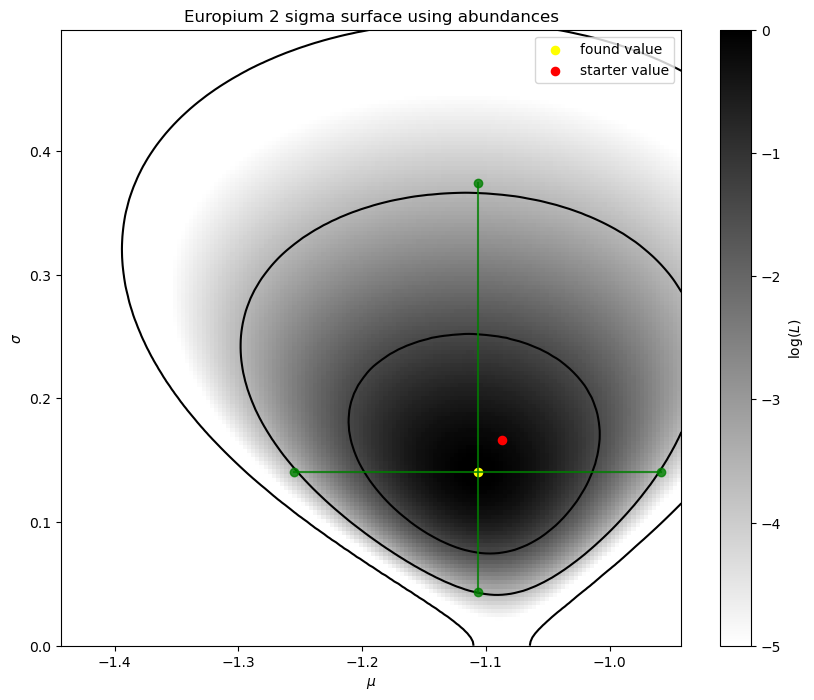

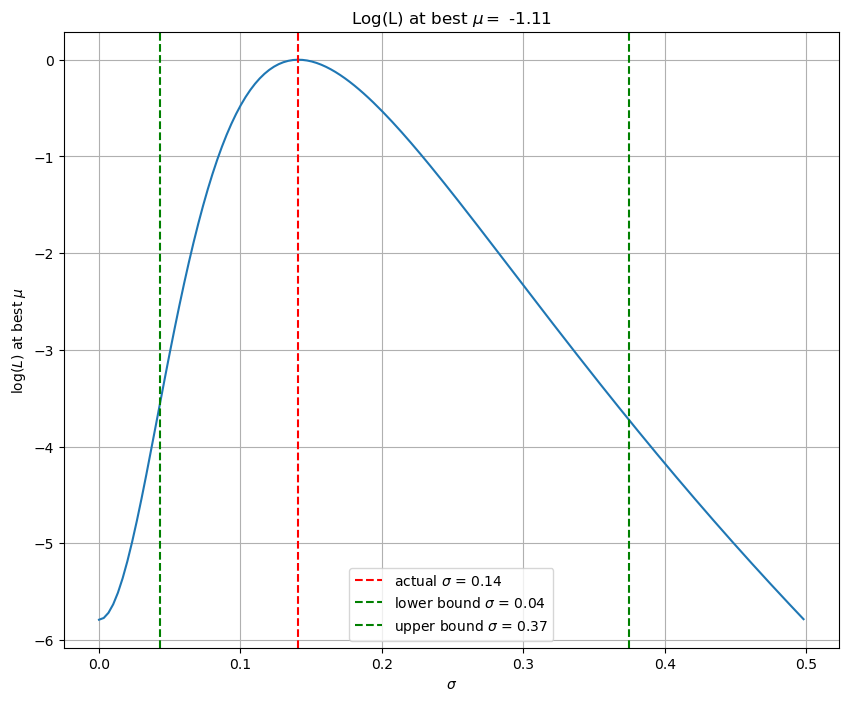

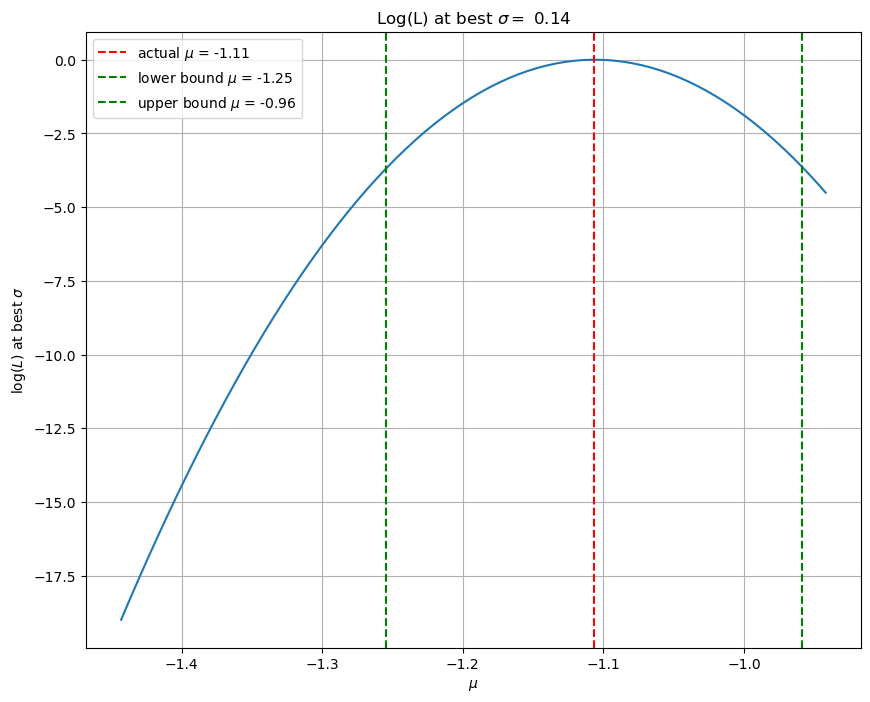

The best sigma we got is 0.14
Corresponding lower and upper bound for instrisic dispersion 2 z-score are 0.04 and 0.37
Thus, our $\sigma_i$ within a 2-zscore interval is 0.14 - 0.10 and 0.14 + 0.23


The best mu we got is -1.11
Corresponding lower and upper bound for mean abundance at 2 z-score are -1.25 and -0.96
Thus, our $\mu_i$ within a 2-zscore interval is -1.11 - 0.15 and -1.11 + 0.15


In [19]:
#Test out above functions with M15 data

M15_abunds = avg_abunds[0]

Na_index = np.where(M15_abunds['element'] == 'Na')[0][0]
Eu_index = np.where(M15_abunds['element'] == 'Eu')[0][0]
Nd_index = np.where(M15_abunds['element'] == 'Nd')[0][0]

sodium_M15 = M15_abunds.iloc[Na_index]['abund']
sodium_M15_error = M15_abunds.iloc[Na_index]['abunderr']

europium_M15 = M15_abunds.iloc[Eu_index]['abund']
europium_M15_error = M15_abunds.iloc[Eu_index]['abunderr']
europium_M15_reldiffs = M15_abunds.iloc[Eu_index]['abunddiff']
europium_M15_reldiffs_error = M15_abunds.iloc[Eu_index]['abunddifferr']


neodymium_M15 = M15_abunds.iloc[Nd_index]['abund']
neodymium_M15_error = M15_abunds.iloc[Nd_index]['abunderr']

mu_actual, diff_lower_mu, diff_upper_mu, sigma_actual, diff_lower_disp, diff_upper_disp = get_likelihood(np.array(europium_M15), np.array(europium_M15_error), z_score = 2, plot = True, title = 'Europium 2 sigma surface using abundances')

#get_likelihood(np.array(europium_M15_reldiffs), np.array(europium_M15_reldiffs_error), z_score = 2, plot = True, title = 'Europium 2 sigma surface using relative differences')